# WeRateDogs Data Wrangling and Analyzing

## Table of Contents

<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#gather">Gathering Data</a></li>
<li><a href="#assess">Assessing Data</a></li>
<li><a href="#clean">Cleaning Data</a></li>
<li><a href="#store">Storing, Analyzing and Visualizing</a></li>    
</ul>

<a id='intro'></a>
## Introduction

In this project, I am applying my data wrangling skill learned from Udacity Data Analyst Nanodegree. The dataset that I will be wrangling is the tweet archive of Twitter user @dog_rates, also known as WeRateDogs.

<a id='gather'></a>
## Gathering Data

There are 3 pieces of data that need to be gathered from a variety of sources and in a variety of formats:
1. The WeRateDogs Twitter archive given by the instructor in csv format.
2. The tweet image predictions, i.e., what breed of dog (or other object, animal, etc.) is present in each tweet according to a neural network. This file (image_predictions.tsv) is hosted on Udacity's servers and should be downloaded programmatically using the Requests library and the following URL: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv
3. Each tweet's retweet count and favorite ("like") count at minimum, and any additional data you find interesting. Using the tweet IDs in the WeRateDogs Twitter archive, query the Twitter API for each tweet's JSON data using Python's Tweepy library and store each tweet's entire set of JSON data in a file called tweet_json.txt file.

In [261]:
#Import all necessary packages
import pandas as pd
import requests
import tweepy
import time
import json
import re
import matplotlib.pyplot as plt
%matplotlib inline

##### 1. Twitter archive file

In [2]:
#Read the twitter archive csv file
df = pd.read_csv('twitter-archive-enhanced.csv')

##### 2. Tweet image predictions

In [3]:
#Download the tweet image predictions using Requests library
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
url_data = requests.get(url)
with open('image-predictions.tsv', mode='wb') as file:
    file.write(url_data.content)
    
#Import the tweet image predictions into a dataframe
image_data = pd.read_csv('image-predictions.tsv', sep='\t')

##### 3. Twitter API & JSON

In [4]:
#Twitter API keys and tokens
consumer_key = 'a3xSBVPIOUxyzsO9PlUhRtwoy'
consumer_secret = 'jlru3R0cNx83nIDcZu0fOEWiM82EfV8IWxJ3QoqyhGUJfZciNC'
access_token = '100682582-8fCegSf8upOyufHNnL11pw0BTIQVhncffZP7csMY'
access_secret = 'FWh9DWlNFleAt3ie238Pl7EkQxzXKhA3vzc70cKpaCD4y'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

In [5]:
api = tweepy.API(auth_handler=auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [6]:
#Query Twitter API for each tweet's JSON using the tweet IDs in the twitter archive file

#Start timer
start = time.time()

with open('getstatus_error.txt', 'w') as error_file:
    valid_ids = 0
    error_ids = 0
    tweet_ids = df['tweet_id']
    with open('tweet_json.txt', 'w', encoding='utf-8') as outfile:
        for i, tweet_id in tweet_ids.iteritems():
            try:
                print("%s# %s" % (str(i+1), tweet_id))
                #Get tweet data from Twitter API
                tweet = api.get_status(tweet_id, tweet_mode='extended')
                json_content = tweet._json
                
                #Write each tweet's JSON data to its own line in a file
                json.dump(json_content, outfile)
                outfile.write('\n')
                valid_ids += 1
            except tweepy.TweepError as e:
                error_ids += 1
                error_str = []
                error_str.append(str(tweet_id))
                error_str.append(': ')
                error_str.append(e.response.json()['errors'][0]['message'])
                error_str.append('\n')
                error_file.write(''.join(error_str))
                print(''.join(error_str))
                continue
        print("%s %s" % ('Valid tweets:', valid_ids))
        print("%s %s" % ('Error tweets:', error_ids))

#End timer
end = time.time()
print((end - start)/(1000*60))

1# 892420643555336193
2# 892177421306343426
3# 891815181378084864
4# 891689557279858688
5# 891327558926688256
6# 891087950875897856
7# 890971913173991426
8# 890729181411237888
9# 890609185150312448
10# 890240255349198849
11# 890006608113172480
12# 889880896479866881
13# 889665388333682689
14# 889638837579907072
15# 889531135344209921
16# 889278841981685760
17# 888917238123831296
18# 888804989199671297
19# 888554962724278272
20# 888202515573088257
888202515573088257: No status found with that ID.

21# 888078434458587136
22# 887705289381826560
23# 887517139158093824
24# 887473957103951883
25# 887343217045368832
26# 887101392804085760
27# 886983233522544640
28# 886736880519319552
29# 886680336477933568
30# 886366144734445568
31# 886267009285017600
32# 886258384151887873
33# 886054160059072513
34# 885984800019947520
35# 885528943205470208
36# 885518971528720385
37# 885311592912609280
38# 885167619883638784
39# 884925521741709313
40# 884876753390489601
41# 884562892145688576
42# 88444180538

In [7]:
#Read tweet's JSON data line by line and store in dictionary that is converted to dataframe
json_dict = []
with open('tweet_json.txt', 'r') as json_file:
    for line in json_file:
        status = json.loads(line)
        
        #Append to the empty dictionary
        json_dict.append({'tweet_id': status['id'],
                         'retweet_count': status['retweet_count'],
                         'favorite_count': status['favorite_count'],
                         'display_text_range': status['display_text_range']
                         })

#Convert dictionary to a dataframe
tweet_df = pd.DataFrame(json_dict, columns = ['tweet_id', 'retweet_count', 'favorite_count', 'display_text_range'])

<a id='assess'></a>
## Assessing Data

I am using visual and programmatical assessment to identify any Quality (content) and Tidiness (structure) issues in the dataframe. All of the issues will be documented at the end of this section.

##### Visual Assessment

Display all three gathered data for visual assessment purposes

In [21]:
df.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2216,668537837512433665,NaN,NaN,2015-11-22 21:13:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Spark. He's nervous. Other dog hasn't ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/668537837...,8,10,Spark,None,None,None,None
1458,695074328191332352,NaN,NaN,2016-02-04 02:40:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Lorenzo. He's educated af. Just gradua...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/695074328...,11,10,Lorenzo,None,None,pupper,None
2094,670778058496974848,NaN,NaN,2015-11-29 01:35:26 +0000,"<a href=""http://twitter.com/download/iphone"" r...","""To bone or not to bone?""\n10/10 https://t.co/...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/670778058...,10,10,None,None,None,None,None
1697,681231109724700672,NaN,NaN,2015-12-27 21:52:07 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I just love this pic. 11/10 this pupper is goi...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/681231109...,11,10,None,None,None,pupper,None
186,856288084350160898,8.562860e+17,279280991.0,2017-04-23 23:26:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@xianmcguire @Jenna_Marbles Kardashians wouldn...,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
766,777684233540206592,NaN,NaN,2016-09-19 01:42:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...","""Yep... just as I suspected. You're not flossi...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/777684233...,12,10,None,None,None,None,None
797,773191612633579521,NaN,NaN,2016-09-06 16:10:20 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Grey. He's the dogtor in charge of you...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/773191612...,12,10,Grey,None,None,None,None
260,842892208864923648,NaN,NaN,2017-03-18 00:15:37 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Stephan. He just wants ...,8.071068e+17,4.196984e+09,2016-12-09 06:17:20 +0000,https://twitter.com/dog_rates/status/807106840...,13,10,Stephan,None,None,None,None
1405,699323444782047232,NaN,NaN,2016-02-15 20:04:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...","""I'm bathing the children what do you want?"" ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/699323444...,10,10,None,None,None,None,None
1729,679862121895714818,NaN,NaN,2015-12-24 03:12:15 +0000,"<a href=""http://twitter.com/download/iphone"" r...","""Dammit hooman I'm jus trynna lik the fler"" 11...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/679862121...,11,10,None,None,None,None,None


In [23]:
image_data.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
507,676089483918516224,https://pbs.twimg.com/media/CWHzzFGXIAA0Y_H.jpg,1,bull_mastiff,0.743808,True,boxer,0.106697,True,American_Staffordshire_terrier,0.042335,True
104,667832474953625600,https://pbs.twimg.com/media/CUSeGFNW4AAyyHC.jpg,1,miniature_pinscher,0.214200,True,bath_towel,0.146789,False,Chihuahua,0.104152,True
1915,854365224396361728,https://pbs.twimg.com/media/C9tQokgUIAEETSx.jpg,1,Pembroke,0.907080,True,Cardigan,0.086272,True,Chihuahua,0.001413,True
1748,823581115634085888,https://pbs.twimg.com/media/C23ypm6VQAAO31l.jpg,1,dingo,0.280949,False,German_shepherd,0.194044,True,Pembroke,0.120051,True
766,689154315265683456,https://pbs.twimg.com/media/CZBeMMVUwAEdVqI.jpg,1,cocker_spaniel,0.816044,True,golden_retriever,0.054135,True,Airedale,0.030648,True
292,671186162933985280,https://pbs.twimg.com/media/CVCIQX7UkAEzqh_.jpg,1,Chihuahua,0.319106,True,whippet,0.169134,True,toy_terrier,0.125815,True
479,675349384339542016,https://pbs.twimg.com/media/CV9SrABU4AQI46z.jpg,3,borzoi,0.866367,True,Saluki,0.122079,True,Irish_wolfhound,0.004020,True
1822,834786237630337024,https://pbs.twimg.com/media/C5XBp19WYAA5a_v.jpg,1,Border_terrier,0.156276,True,Norwegian_elkhound,0.125912,True,Boston_bull,0.096624,True
1710,818259473185828864,https://pbs.twimg.com/media/C1sKo_QUkAALtkw.jpg,1,miniature_schnauzer,0.367368,True,toy_poodle,0.112479,True,standard_schnauzer,0.095434,True
501,675853064436391936,https://pbs.twimg.com/media/CWEcxqWVEAAHyGH.jpg,1,Labrador_retriever,0.868367,True,golden_retriever,0.043305,True,vizsla,0.028207,True


In [24]:
tweet_df.sample(10)

,tweet_id,retweet_count,favorite_count,display_text_range
279,838476387338051585,5092,23471,"[0, 114]"
1860,675109292475830276,1179,2844,"[0, 137]"
764,776088319444877312,164,1929,"[0, 113]"
1867,674800520222154752,888,3062,"[0, 137]"
1675,681320187870711809,796,2756,"[0, 100]"
1703,680161097740095489,779,2409,"[0, 139]"
1052,740373189193256964,14057,36182,"[0, 116]"
1015,745422732645535745,2571,8937,"[0, 116]"
2184,668645506898350081,541,893,"[0, 108]"
843,763837565564780549,4466,13260,"[0, 63]"


##### Programmatic Assessment

Use Pandas to assess the data

In [25]:
#Check the datatypes of the twitter archive table columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [26]:
#Check the datatypes of the image data table columns
image_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [27]:
#Check the datatypes of the twitter API table columns
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2339 entries, 0 to 2338
Data columns (total 4 columns):
tweet_id              2339 non-null int64
retweet_count         2339 non-null int64
favorite_count        2339 non-null int64
display_text_range    2339 non-null object
dtypes: int64(3), object(1)
memory usage: 73.2+ KB


In [28]:
#Check to see if any tweet id in id is a duplicate
sum(df['tweet_id'].duplicated())

0

In [29]:
#Sort the rating denominator in df table
df['rating_denominator'].value_counts().sort_index()

0         1
2         1
7         1
10     2333
11        3
15        1
16        1
20        2
40        1
50        3
70        1
80        2
90        1
110       1
120       1
130       1
150       1
170       1
Name: rating_denominator, dtype: int64

In [30]:
#Sort the rating numerator in df table
df['rating_numerator'].value_counts().sort_index()

0         2
1         9
2         9
3        19
4        17
5        37
6        32
7        55
8       102
9       158
10      461
11      464
12      558
13      351
14       54
15        2
17        1
20        1
24        1
26        1
27        1
44        1
45        1
50        1
60        1
75        2
80        1
84        1
88        1
99        1
121       1
143       1
144       1
165       1
182       1
204       1
420       2
666       1
960       1
1776      1
Name: rating_numerator, dtype: int64

In [31]:
#See all the dog names in df table
df['name'].value_counts().sort_index()

Abby             2
Ace              1
Acro             1
Adele            1
Aiden            1
Aja              1
Akumi            1
Al               1
Albert           2
Albus            2
Aldrick          1
Alejandro        1
Alexander        1
Alexanderson     1
Alf              1
Alfie            5
Alfy             1
Alice            2
Amber            1
Ambrose          1
Amy              1
Amélie           1
Anakin           2
Andru            1
Andy             1
Angel            1
Anna             1
Anthony          1
Antony           1
Apollo           1
                ..
Ziva             1
Zoe              1
Zoey             3
Zooey            1
Zuzu             1
a               55
actually         2
all              1
an               7
by               1
getting          2
his              1
incredibly       1
infuriating      1
just             4
life             1
light            1
mad              2
my               1
not              2
officially       1
old         

In [32]:
##Check if there are any retweets in Twitter Archive data (we only want original posts)
df[df['retweeted_status_id'].isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [33]:
#Check if any dogs have more than 1 stage listed
print(len(df[(df.doggo != 'None') & (df.floofer != 'None')]))
print(len(df[(df.doggo != 'None') & (df.pupper != 'None')]))
print(len(df[(df.doggo != 'None') & (df.puppo != 'None')]))
print(len(df[(df.floofer != 'None') & (df.pupper != 'None')]))
print(len(df[(df.floofer != 'None') & (df.puppo != 'None')]))
print(len(df[(df.pupper != 'None') & (df.puppo != 'None')]))

1
12
1
0
0
0


In [34]:
#Check the image_data table for any duplicate
sum(image_data['jpg_url'].duplicated())

66

### Quality

Completeness, validity, accuracy, consistency (content)

##### Twitter archive data (df)
- There are retweet entries (we only want original posts)
- Rating denominator column has value other than 10
- Rating numerator column has value less than 10 and large numbers
- Name column has erroneous entries (such as 'a', 'an', 'actually')
- Erroneous datatypes (in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id columns)
- There are 14 dogs that have more than 1 dog stages

##### Tweet image predictions (image_data)
- Missing data (only 2075 rows instead of 2356)
- There are 66 duplicate jpg_url entries
- Image predictions might not be actual dog breed (example: bow tie)

### Tidiness

- Dog stage variable is not in the same column
- Some columns are not needed in this analysis
- All data should be combined into one table

<a id='clean'></a>
## Cleaning Data

In this section, I will fix the issues I identified in the Assessing step using codes. After this section, the data should be clean and ready for analysis and visualization.

In [324]:
#Create a copy of all dataframes to do the cleaning on
df_clean = df.copy()
image_clean = image_data.copy()
tweet_clean = tweet_df.copy()

### Quality

1. Twitter archive data: There are retweet entries (we only want original posts)

#### Define

Remove all entries that are retweet (we only want to keep original tweets) and drop the columns concerning retweet info

#### Code

In [325]:
df_clean = df_clean[df_clean['retweeted_status_id'].isnull()]
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null object
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
dtypes: float64(4), int64(3), object(1

#### Test

In [326]:
print(len(df_clean[df_clean['retweeted_status_id'].isnull() == False]))
df_clean.info()

0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null object
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
dtypes: float64(4), int64(3), object

In [327]:
#Drop retweeted_status_id, retweeted_status_user_id and retweeted_status_timestamp columns since they are empty
df_clean = df_clean.drop(['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis=1)

2. Tweet image predictions data: missing data

#### Define

Keep only the rows in twitter archive data with existing tweet_id data in tweet image predictions data

#### Code

In [328]:
df_clean = df_clean[df_clean['tweet_id'].isin(image_clean['tweet_id'])]

#### Test

In [329]:
len(df_clean[~df_clean['tweet_id'].isin(image_clean['tweet_id'])])

0

3. Twitter archive data: Erroneous datatypes (in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id columns)

#### Define

Convert the in_reply_to_status_id & in_reply_to_user_id from float to string using astype.
The retweeted_status_id & retweeted_status_user_id columns are already dropped.

#### Code

In [330]:
df_clean['in_reply_to_status_id'] = df_clean['in_reply_to_status_id'].astype('str')
df_clean['in_reply_to_user_id'] = df_clean['in_reply_to_user_id'].astype('str')

#### Test

In [331]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id                 1994 non-null int64
in_reply_to_status_id    1994 non-null object
in_reply_to_user_id      1994 non-null object
timestamp                1994 non-null object
source                   1994 non-null object
text                     1994 non-null object
expanded_urls            1994 non-null object
rating_numerator         1994 non-null int64
rating_denominator       1994 non-null int64
name                     1994 non-null object
doggo                    1994 non-null object
floofer                  1994 non-null object
pupper                   1994 non-null object
puppo                    1994 non-null object
dtypes: int64(3), object(11)
memory usage: 233.7+ KB


4. Twitter archive data: rating denominators have values other than 10

#### Define

Fix the rating denominators that are not actual ratings (multiple #/# in the 'text column)

#### Code

In [332]:
#All occurences where there are more than one #/#'s in the text column
ratings_multiple = df_clean[df_clean['text'].str.contains( r"(\d+\.?\d*\/\d+\.?\d*\D+\d+\.?\d*\/\d+\.?\d*)")].text
ratings_multiple

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


766     "Yep... just as I suspected. You're not flossi...
1007    This is Bookstore and Seaweed. Bookstore is ti...
1068    After so many requests, this is Bretagne. She ...
1165    Happy 4/20 from the squad! 13/10 for all https...
1202    This is Bluebert. He just saw that both #Final...
1222    Meet Travis and Flurp. Travis is pretty chill ...
1359    This is Socks. That water pup w the super legs...
1459    This may be the greatest video I've ever been ...
1465    Meet Oliviér. He takes killer selfies. Has a d...
1508    When bae says they can't go out but you see th...
1525    This is Eriq. His friend just reminded him of ...
1538    Meet Fynn &amp; Taco. Fynn is an all-powerful ...
1662    This is Darrel. He just robbed a 7/11 and is i...
1795    Meet Tassy &amp; Bee. Tassy is pretty chill, b...
1832    These two pups just met and have instantly bon...
1897    Meet Rufio. He is unaware of the pink legless ...
1901    Two gorgeous dogs here. Little waddling dog is...
1970    Meet E

In [333]:
for entry in ratings_multiple:
    mask = df_clean['text'] == entry
    column_name1 = 'rating_numerator'
    column_name2 = 'rating_denominator'
    df_clean.loc[mask, column_name1] = re.findall(r"\d+\.?\d*\/\d+\.?\d*\D+(\d+\.?\d*)\/\d+\.?\d*", entry)
    df_clean.loc[mask, column_name2] = 10

#### Test

In [334]:
df_clean['rating_denominator'].value_counts()

10     1981
80        2
50        2
170       1
150       1
130       1
120       1
110       1
90        1
70        1
40        1
7         1
Name: rating_denominator, dtype: int64

#### Define

For records whose rating_denominator is greater than 10 and divisible by 10, use the quotient as the divisor to divide the rating_numerator. If the numerator turns out to be divisible (i.e. remainder=0), assign this quotient as the rating_numerator.

#### Code

In [335]:
#Iterate for all records with rating denominator not equal to 10
for i, row in df_clean[df_clean['rating_denominator'] != 10].iterrows():
    d = row['rating_denominator']
    
    #If rating denominator is greater than 10 and divisible by 10
    if d > 10 and d%10 == 0:
        # assign divisor as the quotient
        divisor = d/10
        n = row['rating_numerator']
        
        #If rating_numerator is divisible by the divisor
        if n%divisor == 0:
            # reassign rating_denominator as 10
            df_clean.set_value(i, 'rating_denominator', 10)
            # reassign rating_numerator as the quotient of rating_numerator by divisor
            df_clean.set_value(i, 'rating_numerator', int(n/divisor))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  app.launch_new_instance()


#### Test

In [336]:
df_clean['rating_denominator'].value_counts()

10    1993
7        1
Name: rating_denominator, dtype: int64

5. Twitter archive data: rating numerator has values less than 10 and large numbers

#### Define

For rating numerator values that are lower than 10 or higher than 10 but are considered large (greater than 14), check if the text has a fraction and if it does, extract the numerator value from that fraction as the rating numerator

#### Code

In [337]:
# regex to match fractions
pattern = "\s*(\d+([.]\d+)?([/]\d+))"

# function which will match the above pattern and return an array of fractions, if any
def tokens(x):
  return [m.group(1) for m in re.finditer(pattern, x)]

In [338]:
#Convert rating numerator column to int
df_clean['rating_numerator'] = df_clean['rating_numerator'].astype('int')
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id                 1994 non-null int64
in_reply_to_status_id    1994 non-null object
in_reply_to_user_id      1994 non-null object
timestamp                1994 non-null object
source                   1994 non-null object
text                     1994 non-null object
expanded_urls            1994 non-null object
rating_numerator         1994 non-null int64
rating_denominator       1994 non-null int64
name                     1994 non-null object
doggo                    1994 non-null object
floofer                  1994 non-null object
pupper                   1994 non-null object
puppo                    1994 non-null object
dtypes: int64(3), object(11)
memory usage: 313.7+ KB


In [339]:
for i, row in df_clean[(df_clean.rating_numerator <= 10) | (df_clean.rating_numerator > 14)].iterrows():
    ratings = tokens(row.text)
    for rating in ratings:        
        if rating.split('/')[1] == '10':
            n = int(round(float(rating.split('/')[0])))
            if (row.rating_numerator == 10 and n > 10) or (row.rating_numerator != 10 and n >= 10):
                df_clean.set_value(i, 'rating_numerator', n)
                break

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  import sys


In [378]:
#Remove outliers from rating_numerator column for analysis
df_clean = df_clean[(df_clean['rating_numerator'] < 15)]

#### Test

In [379]:
df_clean['rating_numerator'].value_counts()

12    453
10    422
11    408
13    263
9     151
8      95
7      50
14     37
6      32
5      30
3      19
4      14
2      10
1       5
0       2
Name: rating_numerator, dtype: int64

6. Twitter archive data: erroneous name columns (for example: 'a', 'an', 'actually'

#### Define

Replace all lowercase names with 'None'

#### Code

In [344]:
df_clean['name'][df_clean['name'].str.match('[a-z]+')] = 'None'

#### Test

In [345]:
df_clean['name'].value_counts().sort_index()

Abby            2
Ace             1
Acro            1
Adele           1
Aiden           1
Aja             1
Akumi           1
Al              1
Albert          2
Albus           2
Aldrick         1
Alejandro       1
Alexander       1
Alexanderson    1
Alf             1
Alfie           4
Alfy            1
Alice           2
Amber           1
Ambrose         1
Amy             1
Amélie          1
Anakin          1
Andru           1
Andy            1
Angel           1
Anna            1
Anthony         1
Antony          1
Apollo          1
               ..
Waffles         3
Walker          1
Wallace         3
Wally           2
Walter          3
Watson          2
Wesley          1
Wiggles         1
Willem          1
William         1
Willie          1
Willow          1
Willy           1
Wilson          3
Winifred        1
Winnie          4
Winston         8
Wishes          1
Wyatt           3
Yoda            1
Yogi            2
Zara            1
Zeek            1
Zeke            3
Zeus      

7. Twitter Archive data: there are some dogs that have more than 1 stage

In [346]:
print(len(df_clean[(df_clean.doggo != 'None') & (df_clean.floofer != 'None')]))
print(len(df_clean[(df_clean.doggo != 'None') & (df_clean.puppo != 'None')]))
print(len(df_clean[(df_clean.doggo != 'None') & (df_clean.pupper != 'None')]))

1
1
9


#### Define

For the 1 record that has both doggo and floofer stages and the 1 record that has both doggo and puppo stages, I will take a look at the text manually and decide which stage is more appropriate.

For the 9 records that have both doggo and pupper stages, I will convert the pupper column to 'None' since the dogtionary mentions that doggo and pupper stages are interchangeable.

#### Code

In [347]:
#Check the texts of the 2 records
for i, row in df_clean[((df_clean.doggo != 'None') & (df_clean.floofer != 'None'))
                   | ((df_clean.doggo != 'None') & (df_clean.puppo != 'None'))].iterrows():
    print('%s %s\n'%(row.tweet_id, row.text))

855851453814013952 Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel

854010172552949760 At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk



From the texts, both of them are not considered to be doggo, so I will convert the doggo column to None for these 2.

In [348]:
df_clean['doggo'][df_clean['tweet_id'].isin([855851453814013952, 854010172552949760])] = 'None'

In [349]:
#Convert pupper column to None for 9 records which have both doggo and pupper
df_clean['pupper'][(df_clean.doggo != 'None') & (df_clean.pupper != 'None')] = 'None'

#### Test

In [350]:
print(len(df_clean[(df_clean.doggo != 'None') & (df_clean.floofer != 'None')]))
print(len(df_clean[(df_clean.doggo != 'None') & (df_clean.puppo != 'None')]))
print(len(df_clean[(df_clean.doggo != 'None') & (df_clean.pupper != 'None')]))

0
0
0


8. Image_data table: duplicate jpg_url

#### Define

Drop all the jpg_url duplicates in image table

#### Code

In [351]:
image_clean = image_clean.drop_duplicates(subset=['jpg_url'], keep='last')

#### Test

In [352]:
sum(image_clean['jpg_url'].duplicated())

0

9. Image data: the first dog breed prediction might not be a dog (for example, bow tie)

#### Define

Extract the first 'True' predictions from the dog type and store in a new dog_breed column

#### Code

In [353]:
#Create a new list for storing dog breed
dog_breed = []

#Create a function to capture the dog breed from the first 'True' prediction
def breed(image_clean):
    if image_clean['p1_dog'] == True:
        dog_breed.append(image_clean['p1'])
    elif image_clean['p2_dog'] == True:
        dog_breed.append(image_clean['p2'])
    elif image_clean['p3_dog'] == True:
        dog_breed.append(image_clean['p3'])
    else:
        dog_breed.append('Error')

#Apply the function on the dataframe
image_clean.apply(breed, axis=1)

#Create new column
image_clean['dog_breed'] = dog_breed

In [354]:
#Drop rows that has prediction_list 'error'
image_clean = image_clean[image_clean['dog_breed'] != 'Error']

#### Test

In [355]:
image_clean.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_breed
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True,Welsh_springer_spaniel
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True,redbone
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True,German_shepherd
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True,Rhodesian_ridgeback
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True,miniature_pinscher


### Tidiness

1. Twitter archive data: dog stages should be in one column

#### Define

Melt the doggo, floofer, pupper and puppo columns to dogs and dogs_stage column. Then drop dogs, doggo, floofer, pupper, and puppo columns.

#### Code

In [356]:
df_clean = pd.melt(df_clean, id_vars=['tweet_id', 
                                      'in_reply_to_status_id',
                                      'in_reply_to_user_id',
                                      'timestamp',
                                      'source',
                                      'text',
                                      'expanded_urls',
                                      'rating_numerator',
                                      'rating_denominator',
                                      'name'],
                   var_name='dogs', value_name='dogs_stage')

In [357]:
df_clean = df_clean.drop('dogs', axis=1)

In [358]:
df_clean = df_clean.sort_values('dogs_stage').drop_duplicates(subset='tweet_id', 
                                                                                        keep='last')

#### Test

In [359]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1992 entries, 1913 to 6110
Data columns (total 11 columns):
tweet_id                 1992 non-null int64
in_reply_to_status_id    1992 non-null object
in_reply_to_user_id      1992 non-null object
timestamp                1992 non-null object
source                   1992 non-null object
text                     1992 non-null object
expanded_urls            1992 non-null object
rating_numerator         1992 non-null int64
rating_denominator       1992 non-null int64
name                     1992 non-null object
dogs_stage               1992 non-null object
dtypes: int64(3), object(8)
memory usage: 186.8+ KB


In [360]:
df_clean['dogs_stage'].value_counts()

None       1686
pupper      203
doggo        72
puppo        23
floofer       8
Name: dogs_stage, dtype: int64

2. Many unnecessary columns in all 3 dataframes and they should be combined into 1 dataframe for analysis

#### Define

Drop unnecessary columns from the dataframes and merge all 3 dataframes into 1

Columns to be dropped from twitter archive data:
in_reply_to_status_id
in_reply_to_user_id
timestamp
source
expanded_urls

Columns to be dropped from image data:
jpg_url
img_num
p1
p1_conf
p1_dog
p2
p2_conf
p2_dog
p3
p3_conf
p3_dog

Columns to be dropped from API data:
display_text_range

#### Code

In [361]:
#Drop columns in twitter archive data
df_clean = df_clean.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp', 'source', 'expanded_urls'], axis=1)

In [362]:
#Drop columns in image data
image_clean = image_clean.drop(['jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'], axis=1)

In [363]:
#Drop columns in API data
tweet_clean = tweet_clean.drop(['display_text_range'], axis=1)

In [364]:
#Merge twitter archive data and image data
df_clean = pd.merge(df_clean, 
                      image_clean, 
                      how = 'left', on = ['tweet_id'])

In [365]:
#Merge twitter API into the main dataframe
df_clean = pd.merge(df_clean, 
                      tweet_clean, 
                      how = 'left', on = ['tweet_id'])

#### Test

In [366]:
df_clean.sample(5)

,tweet_id,text,rating_numerator,rating_denominator,name,dogs_stage,dog_breed,retweet_count,favorite_count
1060,802952499103731712,This is Marley. She's having a ruff day. Prett...,12,10,Marley,None,chow,2186.0,9598.0
178,884925521741709313,This is Earl. He found a hat. Nervous about wh...,12,10,Earl,None,Italian_greyhound,17696.0,75395.0
1763,854010172552949760,"At first I thought this was a shy doggo, but i...",11,10,None,floofer,English_springer,3237.0,16432.0
1232,853299958564483072,This is Rumpole. He'll be your Uber driver thi...,13,10,Rumpole,None,NaN,3682.0,15775.0
1299,858471635011153920,This is Sophie. She just arrived. Used paworit...,13,10,Sophie,None,Pembroke,4895.0,21558.0


In [367]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1992 entries, 0 to 1991
Data columns (total 9 columns):
tweet_id              1992 non-null int64
text                  1992 non-null object
rating_numerator      1992 non-null int64
rating_denominator    1992 non-null int64
name                  1992 non-null object
dogs_stage            1992 non-null object
dog_breed             1626 non-null object
retweet_count         1989 non-null float64
favorite_count        1989 non-null float64
dtypes: float64(2), int64(3), object(4)
memory usage: 155.6+ KB


<a id='store'></a>
## Storing, Analyzing, and Visualizing Data

In [380]:
#Store the clean and merge dataFrame in a CSV file
df_clean.to_csv('twitter_archive_master.csv', 
                 index=False, encoding = 'utf-8')

#### Insight #1 - The most common dog breed in data

In [381]:
#Find the most common dog breed from the breed column
df_clean['dog_breed'].value_counts()

golden_retriever                  142
Labrador_retriever                103
Pembroke                           94
Chihuahua                          87
pug                                60
toy_poodle                         50
chow                               45
Pomeranian                         42
Samoyed                            38
malamute                           32
Chesapeake_Bay_retriever           31
French_bulldog                     30
cocker_spaniel                     26
miniature_pinscher                 24
Eskimo_dog                         22
German_shepherd                    21
Shih-Tzu                           20
Staffordshire_bullterrier          20
Siberian_husky                     20
Cardigan                           19
Maltese_dog                        19
Shetland_sheepdog                  19
Rottweiler                         19
beagle                             19
kuvasz                             18
Lakeland_terrier                   17
basset      

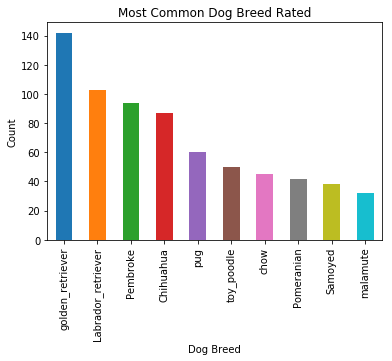

In [382]:
#Plot the 10 most common dog breeds in the data
most_breed = df_clean.groupby('dog_breed').filter(lambda x: len(x) >= 32)

most_breed['dog_breed'].value_counts().plot(kind = 'bar')
plt.title('Most Common Dog Breed Rated')
plt.xlabel('Dog Breed')
plt.ylabel('Count');

#### Insight #2 - Dog breed with the lowest mean rating

In [400]:
breed_rating = df_clean.groupby('dog_breed')['rating_numerator'].mean()
breed_rating.sort_values()

dog_breed
Japanese_spaniel                5.000000
Afghan_hound                    8.000000
soft-coated_wheaten_terrier     8.800000
Walker_hound                    9.000000
Scotch_terrier                  9.000000
Tibetan_terrier                 9.250000
dalmatian                       9.272727
Boston_bull                     9.416667
Saint_Bernard                   9.500000
Welsh_springer_spaniel          9.500000
Dandie_Dinmont                  9.571429
miniature_schnauzer             9.600000
Norwich_terrier                 9.600000
redbone                         9.666667
English_setter                  9.714286
Maltese_dog                     9.736842
Scottish_deerhound              9.750000
Rhodesian_ridgeback             9.750000
Irish_terrier                   9.800000
Airedale                        9.833333
papillon                        9.833333
Newfoundland                    9.857143
Mexican_hairless                9.857143
miniature_poodle                9.875000
Lakela

#### Insight 3 - The dog breed with the most retweet count

In [384]:
breed_retweet = df_clean.groupby('dog_breed')['retweet_count'].mean()
breed_retweet.sort_values(ascending = False)

dog_breed
Bedlington_terrier             7802.166667
English_springer               5413.000000
Saluki                         4802.250000
French_bulldog                 4796.137931
whippet                        4789.181818
Eskimo_dog                     4512.590909
flat-coated_retriever          4243.000000
Great_Pyrenees                 4211.533333
Irish_water_spaniel            4203.333333
Bouvier_des_Flandres           4176.000000
Mexican_hairless               3977.857143
black-and-tan_coonhound        3866.000000
Samoyed                        3778.864865
Lakeland_terrier               3687.470588
Leonberg                       3601.000000
Afghan_hound                   3368.000000
Labrador_retriever             3194.186275
Border_terrier                 3168.428571
golden_retriever               3135.725352
malamute                       3080.718750
cocker_spaniel                 3074.500000
Norwegian_elkhound             2969.600000
Norwich_terrier                2946.400000
C

#### Insight 4 - The relationship between ratings and favorites count

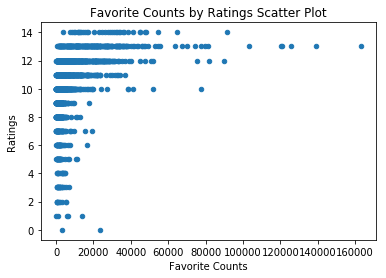

In [385]:
df_clean.plot(x='favorite_count', y='rating_numerator', kind='scatter')
plt.xlabel('Favorite Counts')
plt.ylabel('Ratings')
plt.title('Favorite Counts by Ratings Scatter Plot');

#### Insight 5 - The relationship between ratings and retweet count

Text(0.5,1,'Retweet Counts by Ratings Scatter Plot')

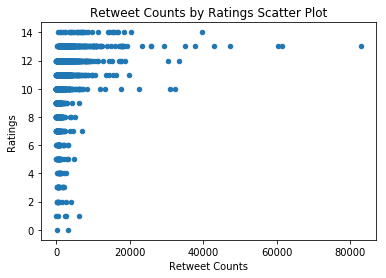

In [386]:
df_clean.plot(x='retweet_count', y='rating_numerator', kind='scatter')
plt.xlabel('Retweet Counts')
plt.ylabel('Ratings')
plt.title('Retweet Counts by Ratings Scatter Plot')

In [388]:
#Check to see which dog post receives the most favorites and retweets
df_clean['favorite_count'].describe()

count      1988.000000
mean       8643.506539
std       12697.165506
min          77.000000
25%        1856.000000
50%        3884.500000
75%       10772.750000
max      162866.000000
Name: favorite_count, dtype: float64

In [389]:
#Check which dog receives the max favorite count
df_clean[df_clean['favorite_count'] == 162866.000000]

,tweet_id,text,rating_numerator,rating_denominator,name,dogs_stage,dog_breed,retweet_count,favorite_count
1736,744234799360020481,Here's a doggo realizing you can stand in a po...,13,10,None,doggo,Labrador_retriever,82879.0,162866.0


In [402]:
#Dog with the lowest average rating
df_clean[df_clean['dog_breed'] == 'Japanese_spaniel']

,tweet_id,text,rating_numerator,rating_denominator,name,dogs_stage,dog_breed,retweet_count,favorite_count
918,677301033169788928,This is Juckson. He's totally on his way to a ...,5,10,Juckson,None,Japanese_spaniel,430.0,1279.0


In [405]:
#Dog with the highest average retweet count
df_clean[df_clean['dog_breed'] == 'Bedlington_terrier']

,tweet_id,text,rating_numerator,rating_denominator,name,dogs_stage,dog_breed,retweet_count,favorite_count
916,678399652199309312,This made my day. 12/10 please enjoy https://t...,12,10,None,None,Bedlington_terrier,33456.0,81711.0
1266,848212111729840128,This is Jerry. He's doing a distinguished tong...,6,10,Jerry,None,Bedlington_terrier,3204.0,16760.0
1306,860524505164394496,This is Carl. He likes to dance. Doesn't care ...,13,10,Carl,None,Bedlington_terrier,5317.0,23573.0
1592,738184450748633089,"For the last time, we only rate dogs. Pls stop...",9,10,None,None,Bedlington_terrier,1273.0,4478.0
1711,752334515931054080,Here's a doggo trying to catch some fish. 8/10...,8,10,None,doggo,Bedlington_terrier,1178.0,3998.0
1727,828381636999917570,Meet Doobert. He's a deaf doggo. Didn't stop h...,14,10,Doobert,doggo,Bedlington_terrier,2385.0,13234.0
